# Summary
In this notebook, following three regression models are used to predict movie ratings in IMDB data.
Models:

(1) Linear Regression, using Scikit-learn

(2) Ridge Regression, using Scikit-learn

(3) Feed Forward Neural Network for regression using Keras


Features Used:

There are all together 7 data files in IMDB data set of which one contains ratings of 954648 movie titles. These file contain important features if used carefully. Here in this project, I have used some of the files to construct important features. Due to time and resource constraints many potential predictive features has been discarded and planned to use in future. Following are the list of features used here:

(1) __titleType__: different people have different preferences; for example short movie, TV Movie etc

(2) __startYear__: it is possible that the choice of movie changes over time because of technology and the plot used over time.

\[__endDate__: is discarded for now. it could be predictive for TV series. Also the startYear and endYear could be used in combination with deathYear to model the effect of Death of an artist, director or writer during which the serial has casted \]

(3) __isAdult__: if movie is adult rated

(4) __runtimeMinutes__: Many young people prefer to watch short movie compared to old people. Hence could be agood feature.

(5) __genres__: Different people have different preferences; Drama, Western, Romance etc.

(6) __localized title (title)__: Indicates in how many different languages are the movie made. Here __count__ of such localized title for each original title are used as features.

(7) __types__: set of attributes for describing localized titles. We binarized these attributes

Total features after feature transformations = __44__

__Note__: The other important features (we discarded for now) such as __directors__, __writers__, __principal actor__, __knownForTitles__ could be used in different ways such as obtaining name embeddings, popularity of the person based upon how many movies he worked on, how many popular people he worked with. The popularity of crew members could be used as popularity weight of movie.

In [104]:
import pandas as pd
import numpy as np

#read data
d_akas = pd.read_csv("data/title.akas.tsv",sep="\t",engine="c",encoding='utf8')

d_basics = pd.read_csv("data/title.basics.tsv",sep="\t",engine="c",encoding='utf8')
d_crew = pd.read_csv("data/title.crew.tsv",sep="\t",engine="c",encoding='utf8')
d_episode = pd.read_csv("data/title.episode.tsv",sep="\t",engine="c",encoding='utf8')
d_principals = pd.read_csv("data/title.principals.tsv",sep="\t",engine="c",encoding='utf8')
d_ratings = pd.read_csv("data/title.ratings.tsv",sep="\t",engine="c",encoding='utf8')
d_name = pd.read_csv("data/name.basics.tsv",sep="\t",engine="c",encoding='utf8')


# print(d_akas[0:10])
# print(d_basics[0:10])
# print(d_crew[0:10])
# print(d_episode[0:10])
# print(d_principals[0:10])
# print(d_ratings[0:10])
# print(d_name[0:10])

/home/dgautam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/dgautam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
print("d_akas",d_akas.shape)
print("d_basics",d_basics.shape)
print("d_episode",d_episode.shape)
print("d_crew",d_crew.shape)
print("d_principals",d_principals.shape)
print("d_ratings",d_ratings.shape)
print("d_name",d_name.shape)




d_akas (3691935, 8)
d_basics (6020773, 9)
d_episode (4192435, 4)
d_crew (6020773, 3)
d_principals (34732384, 6)
d_ratings (954648, 3)
d_name (9461294, 6)


### Clean title.basics table by replacing '\N' in startYear with mode of startYear

In [110]:
#replace \N in startYear with mode of the column 
mode = d_basics[d_basics['startYear']!='\\N']['startYear'].mode()


print("Mode=",mode)
d_basics.loc[d_basics['startYear']  =="\\N", 'startYear'] = mode
d_basics = d_basics.fillna(mode)
# print(d_basics[d_basics['startYear']==float('nan')]['startYear'])

Mode= 0    2017
dtype: object


### take subset of data (because of resource constraint, subset of data is selected for now)

In [111]:
#take subset of data 
numdata = 100000

d_akas = d_akas[0:numdata]

d_basics = d_basics[0:numdata]
d_crew = d_crew[0:numdata]
d_episode = d_episode[0:numdata]
d_principals = d_principals[0:numdata]
d_ratings = d_ratings[0:numdata]
d_name = d_name[0:numdata]


print(d_akas[0:10])
print(d_basics[0:10])
print(d_crew[0:10])
print(d_episode[0:10])
print(d_principals[0:10])
print(d_ratings[0:10])
print(d_name[0:10])


     titleId  ordering                      title region language  \
0  tt0000001         1  Carmencita - spanyol tánc     HU       \N   
1  tt0000001         2                 Καρμενσίτα     GR       \N   
2  tt0000001         3                 Карменсита     RU       \N   
3  tt0000001         4                 Carmencita     US       \N   
4  tt0000001         5                 Carmencita     \N       \N   
5  tt0000002         1     Le clown et ses chiens     \N       \N   
6  tt0000002         2          A bohóc és kutyái     HU       \N   
7  tt0000002         3     Le clown et ses chiens     FR       \N   
8  tt0000002         4      Clovnul si cainii sai     RO       \N   
9  tt0000002         5         Клоун и его собаки     RU       \N   

         types attributes isOriginalTitle  
0  imdbDisplay         \N               0  
1           \N         \N               0  
2           \N         \N               0  
3           \N         \N               0  
4     original      

### inner join title.rating and title.basics to discard all titles that are not labeled

### also remove records from joined data frame if isAdult column not 0 or 1

In [113]:
#join title.rating and title.basics dataframes to eliminate titles that are not labeled
d_labeled = d_ratings.merge(d_basics, left_on='tconst', right_on='tconst', how='inner')

#do some cleaning
#do cleaning
d_l = d_labeled[(d_labeled['isAdult']==0) | (d_labeled['isAdult']==1)]
d_labeled = d_l


d_labeled.shape



(72986, 11)

### one hot encode titleType

In [114]:
#construct features from mearged d_labeled dataframe

#title.basics.titleType types
types = pd.get_dummies(d_labeled['titleType'],prefix='titleType')

types.head(3)



,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,titleType_tvShort,titleType_tvSpecial,titleType_video,titleType_videoGame
0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0


### one hot encode isAdult

In [115]:

#title.basics.isAdult
adult = pd.get_dummies(d_labeled['isAdult'],prefix='isAdult')

adult.head(3)




,isAdult_0,isAdult_1
0,1,0
1,1,0
2,1,0


### expand genre columns to different columns by splitting genres

### binarize the genre by setting value of each of corresponding genres to 1

In [116]:
# import numpy as np

#title.basics.genres
#this feature is binarized
genres = d_labeled["genres"].str.split(",", expand = True).values

unique_genres = set(genres.flatten())
unique_genres.remove(None)
unique_genres.remove("\\N")
# print(unique_genres)

#create genres data matrix with d_labeled x unique_genres
gen = np.zeros((genres.shape[0],len(unique_genres)))
gen = pd.DataFrame(data=gen,columns=list(unique_genres))

#set the values to 1 for the title that belongs to genre
for i in range(gen.shape[0]):
    for g in genres[i]:
        if g is not None and g !="\\N":
            gen.ix[i,g] = 1

gen.head(3)

/home/dgautam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Talk-Show,Mystery,Horror,Drama,Western,Romance,Adventure,Animation,Reality-TV,Game-Show,...,Fantasy,Sport,Family,Crime,Biography,War,Musical,History,News,Short
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Concatenate above constructed features column together

In [117]:

#concatinate types, adult, gen features with d_labeled
d_labeled_features = pd.concat([d_labeled[['tconst','startYear','runtimeMinutes','averageRating']], types, adult, gen], axis=1)
# print(temp_labeled.columns)

d_labeled_features.head(3)
# d_labeled_features.drop('averageRating',axis=1)

# d_labeled_features.head(3)

,tconst,startYear,runtimeMinutes,averageRating,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,...,Fantasy,Sport,Family,Crime,Biography,War,Musical,History,News,Short
0,tt0000001,1894,1,5.8,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,tt0000002,1892,5,6.3,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,tt0000003,1892,4,6.6,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### other features are omitted for now

In [118]:
#TODO create other features


### count the local titles for a title

### count the type of local title

In [119]:
#construct features from title.akas

#count number of local titles
d_akas['n_loc_title'] = 0 #add extra column for counting
d_akas['n_title_type'] = 0 #add extra column for counting
local_title_cnt = d_akas[['titleId', 'n_loc_title']].groupby('titleId',as_index=False).count()

# print(local_title_cnt[0:5])

#count the types of local titles
title_types = d_akas[d_akas['types']!='\\N'][['titleId', 'types','n_title_type']]
# print(title_types.head(10))
title_types_cnt = title_types[['titleId', 'n_title_type']].groupby('titleId',as_index=False).count()


#join the count features
d_akas_features = local_title_cnt.merge(title_types_cnt, left_on='titleId', right_on='titleId', how='inner')



In [120]:
d_akas_features.head(3)

,titleId,n_loc_title,n_title_type
0,tt0000001,5,2
1,tt0000002,6,3
2,tt0000003,6,4


### join above featuers to obtain final features

In [121]:
#join d_akas_features with d_labeled_features

d_final_labeled = d_labeled_features.merge(d_akas_features, left_on='tconst', right_on='titleId', how='inner')

d_final_labeled = d_final_labeled.drop(['titleId',],axis=1)

d_final_labeled.head(3)

,tconst,startYear,runtimeMinutes,averageRating,titleType_movie,titleType_short,titleType_tvEpisode,titleType_tvMiniSeries,titleType_tvMovie,titleType_tvSeries,...,Family,Crime,Biography,War,Musical,History,News,Short,n_loc_title,n_title_type
0,tt0000001,1894,1,5.8,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,2
1,tt0000002,1892,5,6.3,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6,3
2,tt0000003,1892,4,6.6,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4


### separate features (X) and ratings (Y)

### do some imputations

In [124]:
#separate X and Y from labeled features dataframe

d_X = d_final_labeled.drop(['averageRating','tconst'],axis=1)



d_Y = d_final_labeled['averageRating']
# d_labeled_features.drop('averageRating',axis=1)

#do some imputation

#replace \N of runtimeMinutes with average value of runtimeMinutes 

avg = d_X[d_X['runtimeMinutes'] !="\\N"].astype(float)['runtimeMinutes'].to_frame().mean()
# print(avg)
d_X.loc[d_X['runtimeMinutes']  =="\\N", 'runtimeMinutes'] = avg
d_X = d_X.fillna(avg)


# print(d_X[d_X['startYear']!='\\N'])


### Split dataset into testing and training

In [129]:

# #create dummy data. This should be replaced with actual transformed features from IMDB database
# X = {'f1':[1.0, 0.5, 0.7, 2.1, 1.9, 0.9, 1.07, 0.99, 1.05, 2.006], 
# 'f2':[1, 0, 0, 1, 0, 0, 1, 1, 0, 1], 
# 'f3':[1.5, 0.7, 0.66, 1.09, 1.006, 1.34, 1.01, 0.99, 1.1, 1.02],
# 'f4':[1.3, 1.005, 1.1, 0.92, 1.8, 0.98, 1.08, 0.27, 0.36, 1.7],
# 'f5':[1, 1, 1, 0, 0, 0, 1, 0, 1, 1]} 


X = d_X.values
# print(X)
Y = d_Y.values

#split data into training and testing


from sklearn.model_selection import train_test_split

# X, Y = d_ratings['tconst'].to_numpy(), d_ratings['averageRating'].to_numpy()


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Total data: ", X.shape[0])
print("#Training:", X_train.shape[0])
print("#Testing:", X.shape[0]-X_train.shape[0])





Total data:  8123
#Training: 6498
#Testing: 1625


### Linear Regression Model

Training R^2:  0.21078902804834077
Test R^2:  0.1985038709113963
[6.07109252 6.63810387 6.50109678 ... 6.36953602 5.91180417 6.06429708]
[5.3 6.6 7.1 ... 6.6 4.9 5.6]


<function matplotlib.pyplot.show(*args, **kw)>

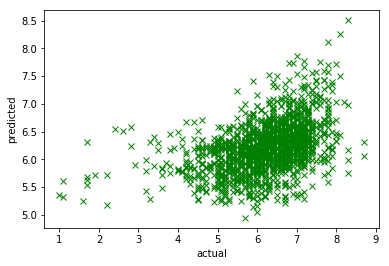

In [153]:
#experiment with linear regression
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(X_train, Y_train)


y_pred = regr.predict(X_test)
y_pred= np.clip(y_pred,0,10) #clip the predicted output to 0-10; the range of movie ratings

print("Training R^2: ", regr.score(X_train,Y_train))
print("Test R^2: ", regr.score(X_test, Y_test))



print(y_pred)
print(Y_test)

import matplotlib.pyplot as plt

plt.plot(Y_test, y_pred,'gx')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show

### Ridge Regression Model

Training R^2:  0.21078074465638577
Test R^2:  0.1985533699699309
[6.07071054 6.63825787 6.50072884 ... 6.3648766  5.91073013 6.06454526]
[5.3 6.6 7.1 ... 6.6 4.9 5.6]


<function matplotlib.pyplot.show(*args, **kw)>

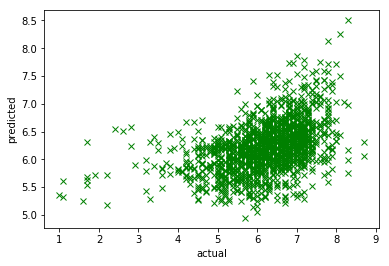

In [154]:
from sklearn.linear_model import Ridge

#experiment with ridge regression
regr = Ridge(alpha=1.0) #regularization = 1.0 chosen

regr.fit(X_train, Y_train) 
y_pred = regr.predict(X_test)
y_pred= np.clip(y_pred,0,10) #clip the predicted output to 0-10; the range of movie ratings

print("Training R^2: ", regr.score(X_train,Y_train))
print("Test R^2: ", regr.score(X_test, Y_test))

print(y_pred)
print(Y_test)

import matplotlib.pyplot as plt

plt.plot(Y_test, y_pred,'gx')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show

### Neural Network model

Training R^2:  0.19894781611099543
Test R^2:  0.1851240847466894
[[6.1208096]
 [6.6878066]
 [6.4415436]
 ...
 [6.038597 ]
 [5.8663783]
 [6.0817013]]
[5.3 6.6 7.1 ... 6.6 4.9 5.6]


<function matplotlib.pyplot.show(*args, **kw)>

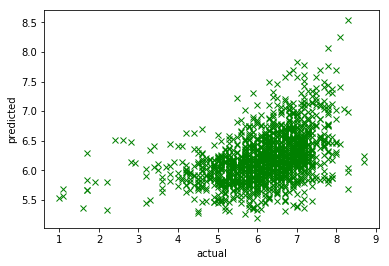

In [155]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

regr = Sequential()
regr.add(Dense(150, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
regr.add(Dense(30, activation='relu'))
regr.add(Dense(1, activation='linear'))

regr.compile(loss='mse', optimizer='adam', metrics=['mse'])

history = regr.fit(X_train, Y_train, epochs=150, batch_size=50,  verbose=0)
# history = regr.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=0, validation_split=0.2)

# model.summary()

y_pred = regr.predict(X_test)
y_pred= np.clip(y_pred,0,10) #clip the predicted output to 0-10; the range of movie ratings



print("Training R^2: ",r2_score(Y_train,regr.predict(X_train)))
print("Test R^2: ", r2_score(Y_test,y_pred))

print(y_pred)
print(Y_test)

import matplotlib.pyplot as plt

plt.plot(Y_test, y_pred,'gx')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show